In [79]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.5)

import olympus
from olympus.datasets import Dataset
from olympus.emulators import Emulator
from olympus.campaigns import Campaign 
from olympus.scalarizers import Scalarizer
from olympus.plotter import Plotter

from olympus.utils.misc import get_hypervolume, get_pareto, get_pareto_set


In [29]:
dataset = Dataset(kind='suzuki_edbo')
values = dataset.targets.values
sort_values = np.sort(values, axis=0)
sort_values = sort_values[::-1]
ranks = {v[0]: i + 1 for i, v in enumerate(sort_values)}

In [98]:
# helper functions



# def get_single_traces(campaigns):
#     traces = []
#     for campaign in campaigns:
#         trace = campaign.best_values
#         assert trace.shape[1]==1
#         traces.append(trace)
#     return np.array(traces).squeeze(axis=-1)
    

# def get_traces(campaigns, scalarizer):
#     traces = []
#     for campaign in campaigns:
# #         print(campaign.observations.get_values().shape)
#         values = campaign.observations.get_values()
#         scalarized = scalarizer.scalarize(values)
#         trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
#         #instance_trace = []
#         trace0 = values[trace_best_idx, 0]
#         trace1 = values[trace_best_idx, 1]
#         trace2 = values[trace_best_idx, 2]
#         traces.append([trace0, trace1, trace2])
#     return np.array(traces)

def get_raw_traces(data, goal='maximize'):
    traces = []
    for d in data:
        trace = d['yield'].cummax().to_numpy()
        traces.append(trace)
        
    return np.array(traces)
    
    
def get_rank_traces(data, goal='maximize'):
    raw_traces = get_raw_traces(data)
    rank_traces = []
    for raw_trace in raw_traces:
        rank_trace = []
        for val_ix, val in enumerate(raw_trace):
            rank_trace.append(ranks[val])
        rank_traces.append(rank_trace)
        
    return np.array(rank_traces)


def get_num_eval_top_k(data, k=20):
    sort_values_k = sort_values[:k]
    num_evals = []
    
    for d in data:
        num_eval = 1
        for val_ix, val in enumerate(d['yield'].to_numpy()):
            if val in sort_values_k:
                break
            else:
                pass
            num_eval+=1
        if num_eval == 201:
            num_eval-=1
        num_evals.append(num_eval)
    
    return np.array(num_evals)
    


    
    
def get_frac_top_k(campaigns, dataset, scalarizer, k):
    ''' returns the fraction of tolerable candidates measuremd at each iteration
    '''
    traces = []
    
    values = dataset.targets.values
    scalarized = scalarizer.scalarize(values)
    sort_idxs = np.argsort(scalarized, axis=0)
    sort_values = [values[i] for i in sort_idxs]
    
    for campaign in campaigns:
        campaign_trace = []
        campaign_values = campaign.observations.get_values()
        for val_ix in range(len(campaign_values)):
            campaign_trace.append(
                sum(val in campaign_values[:val_ix] for val in sort_values)/ len(sort_values)
            )
        traces.append(campaign_trace)
        
    return np.array(traces)
    


def plot_trace_mean(traces, obj_num=None, ax=None, color=None, label=None, use_std_err=True):
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


def plot_num_eval_top_k(df, ax):
    # '#08294C', 
    color = ['#0e4581', '#EB0789', "#75BBE1", "#F75BB6"]
    hue_order=['Random', 'Genetic', 'Hyperopt', 'Botorch']
    _ = sns.boxplot(data=df, x='method', y='num_eval', linewidth=2., ax=ax, palette=color, hue_order=hue_order)
    _ = sns.stripplot(data=df, x='method', y='num_eval', size=8, linewidth=1., ax=ax, palette=color, hue_order=hue_order )
    
    # print out the stats
    for method in df.method.unique():
        sub_df = df[df.method==method]
        mean = sub_df.num_eval.mean()
        stde = sub_df.num_eval.std()/np.sqrt(sub_df.shape[0])
        print(f'{method} mean {mean} stde {stde}')
    
    return None
    
def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

In [92]:
# load the results
res_random = pickle.load(open('RandomSearch/results.pkl', 'rb')) # olympus campaigns
res_hyperopt = pickle.load(open('Hyperopt/results.pkl', 'rb'))   # list of dictionaries
res_deap = pickle.load(open('Genetic/results.pkl', 'rb'))        # list of dataframes
res_botorch = pickle.load(open('Botorch/results.pkl', 'rb'))     # list of olympus campaigns
# res_gryffin

# convert botorch results
data_all_repeats = []
for campaign in res_botorch:
    params = campaign.observations.get_params()
    values = campaign.observations.get_values()
    
    #store run results into a DataFrame
    electrophile = [x[0] for x in params]
    nucleophile = [x[1] for x in params]
    base = [x[2] for x in params]
    ligand = [x[3] for x in params]
    solvent = [x[4] for x in params]

    yield_ = [y[0] for y in values]
    data = pd.DataFrame({ 
        'electrophile': electrophile, 'nucleophile': nucleophile, 'base': base, 'ligand': ligand, 'solvent': solvent,  'yield': yield_,
    })
    data_all_repeats.append(data)
    
res_botorch = data_all_repeats

print('random : ', len(res_random))
print('hyperopt : ', len(res_hyperopt))
print('deap : ', len(res_deap))
print('botorch : ', len(res_botorch))

random :  40
hyperopt :  40
deap :  40
botorch :  40


In [67]:
raw_traces_random = get_raw_traces(res_random)
raw_traces_deap = get_raw_traces(res_deap)
raw_traces_hyperopt = get_raw_traces(res_hyperopt)
raw_traces_botorch = get_raw_traces(res_botorch)

rank_traces_random = get_rank_traces(res_random)
rank_traces_deap = get_rank_traces(res_deap)
rank_traces_hyperopt = get_rank_traces(res_hyperopt)
rank_traces_botorch = get_rank_traces(res_botorch)


k=20
num_evals_random = get_num_eval_top_k(res_random, k=k)
num_evals_deap = get_num_eval_top_k(res_deap, k=k)
num_evals_hyperopt = get_num_eval_top_k(res_hyperopt, k=k)
num_evals_botorch = get_num_eval_top_k(res_botorch, k=k)

dict_ = []
for set_, method in zip([num_evals_random,num_evals_deap,num_evals_hyperopt,num_evals_botorch],['Random', 'Genetic', 'Hyperopt', 'Botorch']):
    for s in set_:
        dict_.append({'method': method, 'num_eval': s})
        
df_num_eval = pd.DataFrame(dict_)

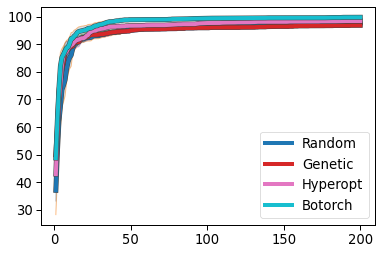

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plot_trace_mean(raw_traces_random, use_std_err=True, label='Random', ax=ax)
plot_trace_mean(raw_traces_deap, use_std_err=True, label='Genetic', ax=ax)
plot_trace_mean(raw_traces_hyperopt, use_std_err=True, label='Hyperopt', ax=ax)
plot_trace_mean(raw_traces_botorch, use_std_err=True, label='Botorch', ax=ax)

ax.legend(loc='lower right')

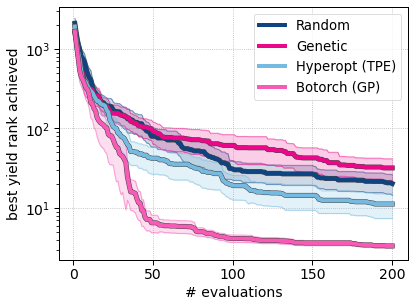

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

#['#0e4581', '#EB0789', "#75BBE1", "#F75BB6"]

plot_trace_mean(rank_traces_random, use_std_err=True, label='Random', ax=ax, color='#0e4581')
plot_trace_mean(rank_traces_deap, use_std_err=True, label='Genetic', ax=ax, color='#EB0789')
plot_trace_mean(rank_traces_hyperopt, use_std_err=True, label='Hyperopt (TPE)', ax=ax, color="#75BBE1")
plot_trace_mean(rank_traces_botorch, use_std_err=True, label='Botorch (GP)', ax=ax, color="#F75BB6")

ax.set_yscale('log')
ax.legend(loc='upper right')

ax.set_ylabel('best yield rank achieved', fontsize=14)
ax.set_xlabel('# evaluations', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle=":")

plt.tight_layout()
plt.savefig('yield_rank_traces_suzuki_edbo.png', dpi=400)

Random mean 127.85 stde 10.761609711829527
Genetic mean 148.35 stde 11.374485054560063
Hyperopt mean 79.5 stde 10.108640629907434
Botorch mean 27.3 stde 2.3575302157021696


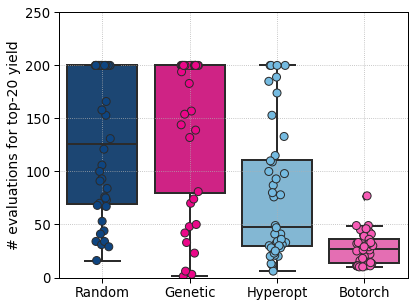

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

plot_num_eval_top_k(df_num_eval, ax=ax)

ax.set_ylabel(f'# evaluations for top-{k} yield', fontsize=14)
ax.set_xlabel(f'')

ax.set_ylim(0, 250)
ax.grid(linestyle=":")

plt.tight_layout()
plt.savefig('yield_boxplots_suzuki_edbo.png', dpi=400)